# Research Project Topic
I will be using simulation data to determine the kinematics of disk stars in the MW and M31 merger remnant at the last Snapshot (800), focusing on rotation, velocities, and dispersions.  

### Question(s) to be pursued
The questions I will be addressing are:
Is the stellar remnant rotating, and is it a fast or slow rotator?

### Overview of Code
First the code creates a CenterofMass object for the disk particles of MW and Andromeda at SnapShot 800, then it converts the data from being with respect to the MW to being with respect to the COM of the remnant and stores it in 3D position and velocity arrays.  It then orients the remnant so that its angular momentum vector is along the z-axis and visualizes what the remnant will look like in various spatial planes (x vs y, y vs z, etc.), as well as creating phase diagrams (x vs vy) etc., v/$\sigma$ as a function of position along various axes.  The code then calculates the average out of page velocity as well as the dispersion for each spatial component along a specified axis.  It then overplots the average perpendicular velocity on top of the corresponding phase diagram, plots the perpendicular dispersion along an axis, and plots the average velocity/dispersion ratio as a function of the axis.  It then finds the maximum average velocity along the axis, and divides it by its corresponding element in the perpendicular and total dispersion array to get the Vmax/$\sigma$ ratio.  Finally, it does similar calculations for the Milky Way at SnapShot 000 for comparison.  

In [1]:
#first, import necessary modules
import numpy as np
import astropy.units as u

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm

%matplotlib inline
from Readfile import Read
from CenterOfMass import CenterOfMass

In [2]:
#since the MW and M31 merge at ~ 6.3 Gyr, pick a snapshot to look at that is a bit of time after that
#I decided to use the last snapshot (Snapshot 800, time = 12 Gyr)

In [3]:
#create a COM object for MW and M31
# Create a Center of mass object for the MW, M31
MWCOM = CenterOfMass("MW_800.txt", 2)
M31COM = CenterOfMass("M31_800.txt", 2)

# MW:   store the position and velocity COM
MW_COMP = MWCOM.COM_P(0.1, 2.0)
print("MW COM Position = ", MW_COMP)
MW_COMV = MWCOM.COM_V(MW_COMP[0], MW_COMP[1], MW_COMP[2])
print("MW COM Velocity = ", MW_COMV)

#M31: store position and velocity COM
M31_COMP = M31COM.COM_P(0.1, 2.0)
print("M31 COM Position = ", M31_COMP)
M31_COMV = M31COM.COM_V(M31_COMP[0], M31_COMP[1], M31_COMP[2])
print("M31 COM Velocity = ", M31_COMV)


MW COM Position =  [190.75  23.58 146.65] kpc
MW COM Velocity =  [ 31.19 -20.28  26.59] km / s
M31 COM Position =  [190.74  23.61 145.83] kpc
M31 COM Velocity =  [ 30.52 -21.89  28.13] km / s


In [4]:
#just set the COM position and velocity of the remnant to be equal to those calculated for the MW since they are 
#pretty similar to that calculated for Andromeda

#remnant COM position and velocity vectors
MergerCOMP = MW_COMP.value
MergerCOMV = MW_COMV.value


#create function to convert all positions and velocities to be with respect to COM of system
def COMDataConverter(filename, particletype):
    #Inputs:
        #filename = name of file to be read in
        #particle type = type of particle (halo, disk, bulge)
    #Returns:
        #position and velocity arrays calculated with respect to center of mass of remnant
    
    #read in file and extract needed data from it
    time, total, data = Read(filename)
    
    #store data for wanted particle type 
    index = np.where(data['type'] == particletype)
    xnew = data['x'][index]
    ynew = data['y'][index]
    znew = data['z'][index]
    vxnew = data['vx'][index]
    vynew = data['vy'][index]
    vznew = data['vz'][index]
    massnew = data['m'][index]
    
    # Store positions and velocities of particles of given ptype from the COMP. 
    xnew2 = np.array(xnew - MergerCOMP[0])
    ynew2 = np.array(ynew - MergerCOMP[1])
    znew2 = np.array(znew - MergerCOMP[2])
    vxnew2 = np.array(vxnew - MergerCOMV[0])
    vynew2 = np.array(vynew - MergerCOMV[1])
    vznew2 = np.array(vznew - MergerCOMV[2])
    
    #return desired quantities
    return xnew2, ynew2, znew2, vxnew2, vynew2, vznew2

In [5]:
#store new position and velocity arrays for both galaxies
xMW, yMW, zMW, vxMW, vyMW, vzMW = COMDataConverter("MW_800.txt", 2)
xM31, yM31, zM31, vxM31, vyM31, vzM31 = COMDataConverter("M31_800.txt", 2)

In [6]:
#combine all component arrays for position and velocity for both MW and M31
xtot = np.concatenate((xMW, xM31))
ytot = np.concatenate((yMW, yM31))
ztot = np.concatenate((zMW, zM31))
vxtot = np.concatenate((vxMW, vxM31))
vytot = np.concatenate((vyMW, vyM31))
vztot = np.concatenate((vzMW, vzM31))

#combine into 3D arrays for position and velocity
r = np.array([xtot,ytot,ztot]).T # transposed 
v = np.array([vxtot,vytot,vztot]).T

In [7]:
#use function to rotate system from Lab 7
# a function that will rotate the position and velocity vectors
# so that the disk angular momentum is aligned with z axis. 

def RotateFrame(posI,velI):
    # input:  3D array of positions and velocities
    # returns: 3D array of rotated positions and velocities such that j is in z direction

    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    # normalize the vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel

In [8]:
#store rotated vectors
rnew, vnew = RotateFrame(r, v)

### Visualization of what the remnant looks like at Snapshot 800 in different spatial planes

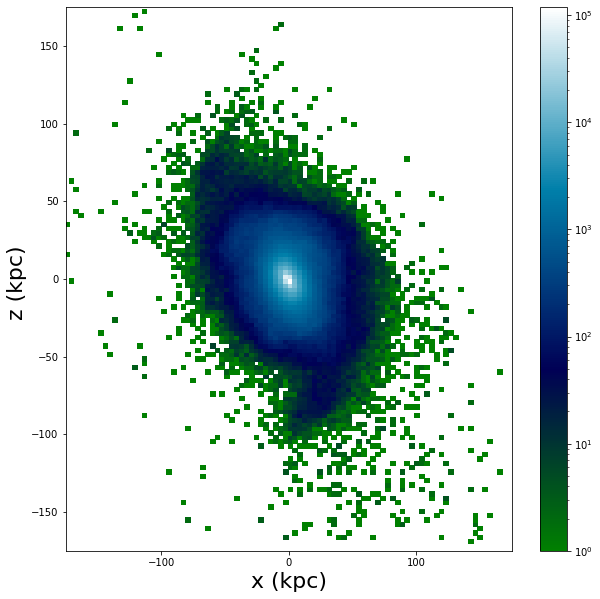

In [9]:
# Rotated Remnant (x-z plane)
#for visualization purposes
# Remnant Density 
fig, ax= plt.subplots(figsize=(10, 10))

# plot the particle density for Remnant , 2D histogram
plt.hist2d(rnew[:,0], rnew[:,2], bins = 150, norm = LogNorm(), cmap = 'ocean')

plt.colorbar()

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('z (kpc) ', fontsize=22)

#set axis limits
plt.ylim(-175,175)
plt.xlim(-175,175)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size



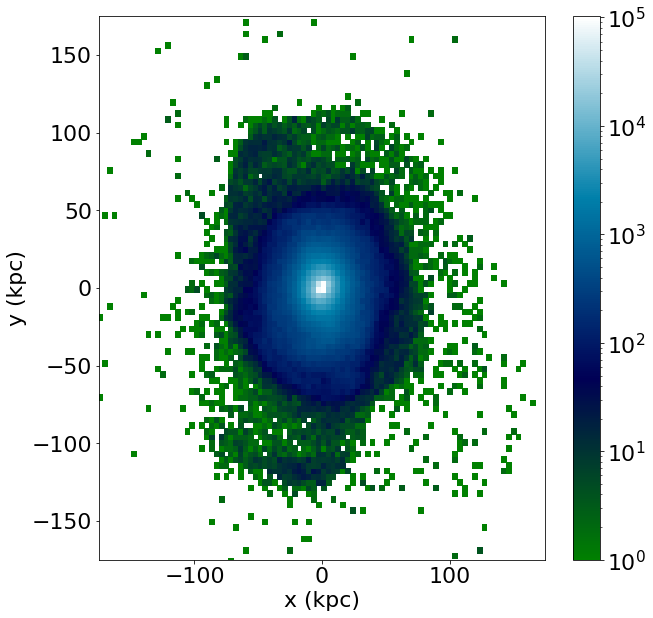

In [10]:
# Rotated Remnant - (x-y plane)

# Remnant Density 
fig, ax= plt.subplots(figsize=(10, 10))

# plot the particle density for remnant 
plt.hist2d(rnew[:,0], rnew[:,1], bins = 150, norm = LogNorm(), cmap = 'ocean')

plt.colorbar()

# make the contour plot
# x pos, y pos, contour res, contour res, axis, colors for contours.

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('y (kpc)', fontsize=22)

#set axis limits
plt.ylim(-175,175)
plt.xlim(-175,175)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size




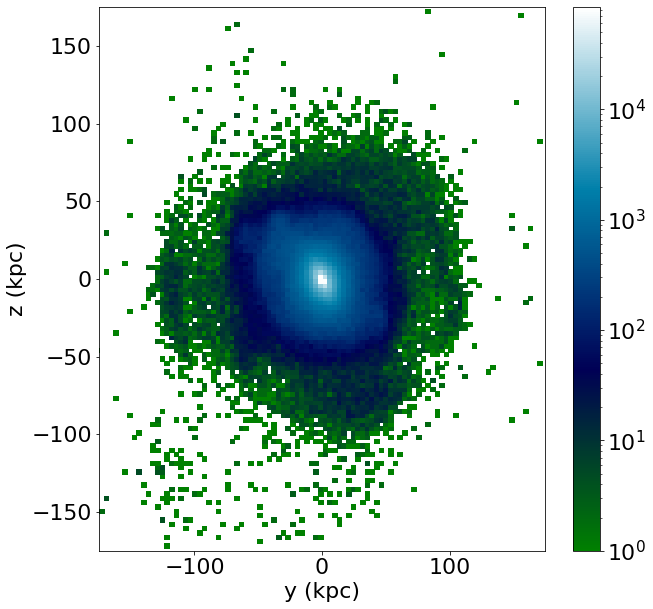

In [11]:
# Rotated Remnant - (y-z plane)

# Remnant Density 
fig, ax= plt.subplots(figsize=(10, 10))

# plot the particle density for remnant 
plt.hist2d(rnew[:,1], rnew[:,2], bins = 150, norm = LogNorm(), cmap = 'ocean')

plt.colorbar()

# make the contour plot
# x pos, y pos, contour res, contour res, axis, colors for contours.

# Add axis labels
plt.xlabel('y (kpc)', fontsize=22)
plt.ylabel('z (kpc)', fontsize=22)

#set axis limits
plt.ylim(-175,175)
plt.xlim(-175,175)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size




### Make phase diagrams of out of page velocity component along an axis

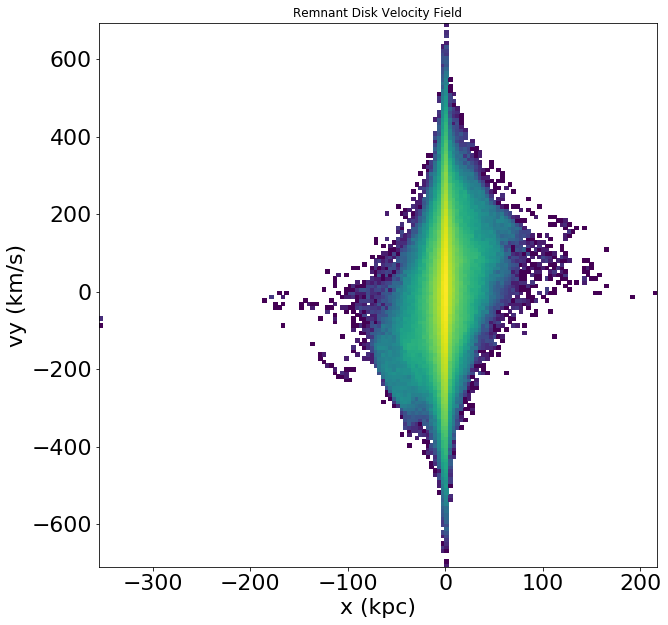

In [12]:
# Make a phase diagram for each x, y, z axis, where v component is component that points out of board
# Remnant Disk Velocity Field (vy vs x)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot 2D Histogram one component of  Pos vs Vel 
plt.hist2d(rnew[:,0], vnew[:,1], bins = 150, norm=LogNorm())

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('vy (km/s)', fontsize=22)
plt.title("Remnant Disk Velocity Field")

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size




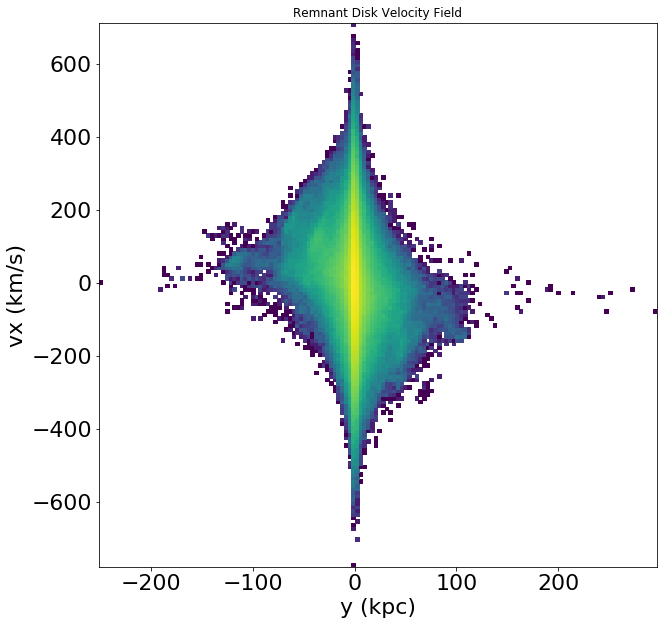

In [13]:
# Make a phase diagram for each x, y, z axis, where v component is component that points out of board
# Remnant Disk Velocity Field. (vx vs y)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot 2D Histogram one component of  Pos vs Vel 
plt.hist2d(rnew[:,1], vnew[:,0], bins = 150, norm=LogNorm())

# Add axis labels
plt.xlabel('y (kpc)', fontsize=22)
plt.ylabel('vx (km/s)', fontsize=22)
plt.title("Remnant Disk Velocity Field")

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size




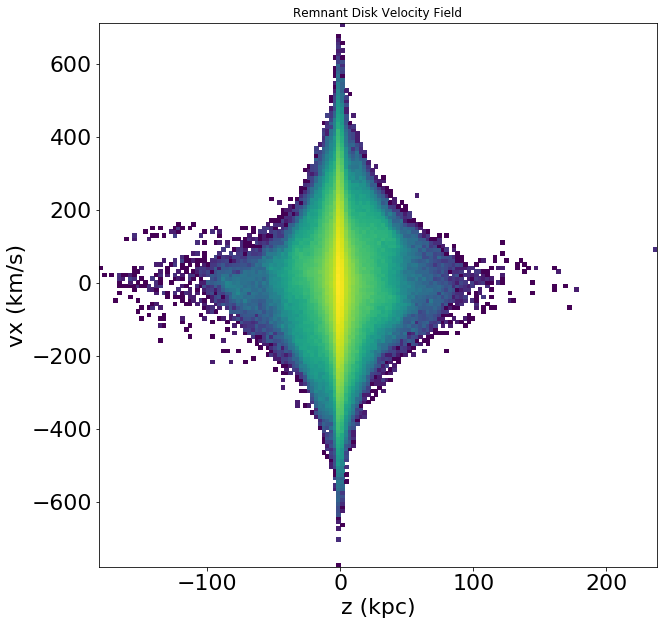

In [14]:
# Make a phase diagram for each x, y, z axis, where v component is component that points out of board
#Remnant Disk Velocity vx vs z

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot 2D Histogram one component of  Pos vs Vel 
plt.hist2d(rnew[:,2], vnew[:,0], bins = 150, norm=LogNorm())

# Add axis labels
plt.xlabel('z (kpc)', fontsize=22)
plt.ylabel('vx (km/s)', fontsize=22)
plt.title("Remnant Disk Velocity Field")

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

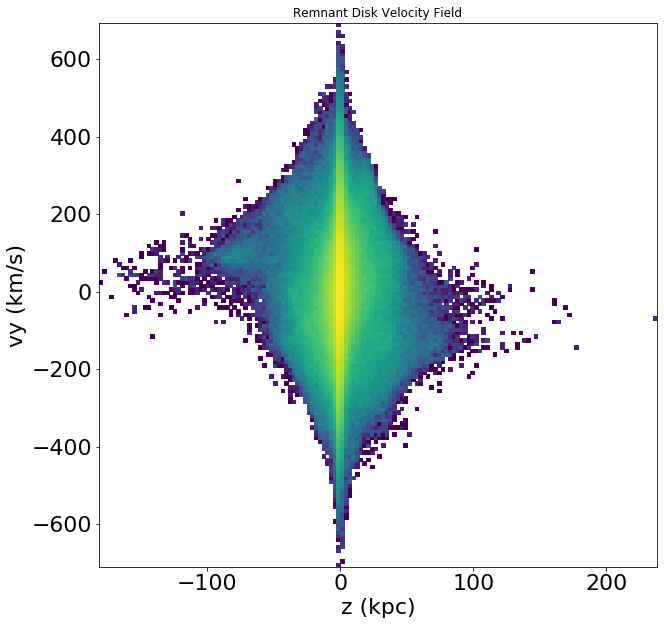

In [15]:
# Make a phase diagram for each x, y, z axis, where v component is component that points out of board
# Remnant Disk Velocity Field vy vs z

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot 2D Histogram one component of  Pos vs Vel 

plt.hist2d(rnew[:,2], vnew[:,1], bins = 150, norm=LogNorm())

# Add axis labels
plt.xlabel('z (kpc)', fontsize=22)
plt.ylabel('vy (km/s)', fontsize=22)
plt.title("Remnant Disk Velocity Field")

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


### Function that calculates the mean velocity and dispersion of velocities along a given axis

In [58]:
#create a function to calculate the mean velocities, and spread of velocities for stars on a given axis
#create a "slit" of points along an axis (e.g. along x-axis, go along chunks of x-axis with dx, where dy and dz are small)
#select points in the slit using index, calculate mean velocity and dispersion within slit along axis

def VelocityMeansandDispersions(axis, rdata, vdata, dx, dy, dz):
    #Inputs: 
        #axis = axis along which mean velocity and dispersion will be calculated
        #rdata = 3D array of positions
        #v = 3D array of velocities
        #dx increment in x
        #dy = increment in y
        #dz = increment in z
    #returns
        #array of mean velocities along axis
        #arrays of dispersion of velocities for every component (vx, vy, vz) along axis
        
    #going to need to take "steps along the strip", so if axis == x, dx = 10, dy = 1, dz = 1
    #for all particles with x coords within dx, dy, dz, find mean velocity and dispersion, store values in 
    #arrays
    if axis == "x":
        #set minimum and maximum values along axis
        #values for remnant (where I can get particles in the bins)
        #xmin = -65.0
        #xmax = 70.0
        
        #values for MW
        xmin = -20.0
        xmax = 20.0
        
        #set bin minimum and maximum for "chunk" of stars to be evaluated
        xbinmin = xmin
        xbinmax = xbinmin + dx
        
        #to set length of means and dispersion arrays, divide the difference between min and max value / dwhatever
        arraylength = (xmax - xmin)/dx
        
        #initialize means and dispersions array
        vmeans = np.zeros(int(arraylength))
        vxdispersions = np.zeros(int(arraylength))
        vydispersions = np.zeros(int(arraylength))
        vzdispersions = np.zeros(int(arraylength))
        
        #initialize dummy index
        i = 0
        
        #loop over values while the maximum bin value is less than the maximum x value
        while xbinmax < xmax:
            #make index to find points within bin minimum and maximum along axis, and have small deviations from axis
            index2 = np.where((rdata[:,0] <= xbinmax) & (rdata[:,0] > xbinmin) & (abs(rdata[:,1]) <= dy) & (abs(rdata[:,2]) <= dz))
            
            #select the velocity values (going out of the page) of the stars that satisfy the index
            vy = vdata[:,1][index2]
            
            #select other velocity values as well
            vx = vdata[:,0][index2]
            vz = vdata[:,2][index2]
        
            
            #calculate the mean and dispersion of the chunk of stars along the axis
            vmeans[i] = np.mean(vy)
            vydispersions[i] = np.std(vy)
            
            #calculate the dispersions in vx and vz as well
            vxdispersions[i] = np.std(vx)
            vzdispersions[i] = np.std(vz)
            
            #increment dummy index, bin minimum, bin maximum
            i = i + 1
            xbinmin = xbinmin + dx
            xbinmax = xbinmax + dx
        
            
    if axis == "y":
        #set minimum and maximum values along axis
        ymin = -65.0 
        ymax = 70.0
        
        #set bin minimum and maximum for "chunk" of stars to be evaluated
        ybinmin = ymin
        ybinmax = ybinmin + dy
        
        #to set length of means and dispersion arrays, divide the difference between min and max value / dwhatever
        arraylength = (ymax - ymin)/dy
        
        #initialize means and dispersions array
        vmeans = np.zeros(int(arraylength))
        vxdispersions = np.zeros(int(arraylength))
        vydispersions = np.zeros(int(arraylength))
        vzdispersions = np.zeros(int(arraylength))
        
        #initialize dummy index
        i = 0
        
        #loop over values while the maximum bin value is less than the maximum x value
        while ybinmax < ymax:
            #make index to find points within bin minimum and maximum along axis, and have small deviations from axis
            index2 = np.where((rdata[:,1] <= ybinmax) & (rdata[:,1] > ybinmin) & (abs(rdata[:,0]) <= dx) & (abs(rdata[:,2]) <= dz))
            
            #select the velocity values (going out of the page) of the stars that satisfy the index
            vx = vdata[:,0][index2]
            
            #select other velocity values as well
            vy = vdata[:,1][index2]
            vz = vdata[:,2][index2]
            
            #calculate the mean and dispersion of the chunk of stars along the axis
            vmeans[i] = np.mean(vx)
            vxdispersions[i] = np.std(vx)
            
            #calculate the dispersions in vx and vz as well
            vydispersions[i] = np.std(vy)
            vzdispersions[i] = np.std(vz)
            
            #increment dummy index, bin minimum, bin maximum
            i = i + 1
            ybinmin = ybinmin + dy
            ybinmax = ybinmax + dy
            
    if axis == "z":
        #set minimum and maximum values along axis
        zmin = -60.0 
        zmax = 70.0
        
        #set bin minimum and maximum for "chunk" of stars to be evaluated
        zbinmin = zmin
        zbinmax = zbinmin + dz
        
        #to set length of means and dispersion arrays, divide the difference between min and max value / dwhatever
        arraylength = (zmax - zmin)/dz
        
        #initialize means and dispersions array
        vmeans = np.zeros(int(arraylength))
        vxdispersions = np.zeros(int(arraylength))
        vydispersions = np.zeros(int(arraylength))
        vzdispersions = np.zeros(int(arraylength))
        
        #initialize dummy index
        i = 0
        
        #loop over values while the maximum bin value is less than the maximum x value
        #calculate mean and dispersion around mean in each loop
        while zbinmax < zmax:
            #make index to find points within bin minimum and maximum along axis, and have small deviations from axis
            index2 = np.where((rdata[:,2] <= zbinmax) & (rdata[:,2] > zbinmin) & (abs(rdata[:,0]) <= dx) & (abs(rdata[:,1]) <= dy))
            
            #select the velocity values (going out of the page) of the stars that satisfy the index 
            #could be x or y axis for looking along z? Does it matter which one? (Chose x for now)
            vy = vdata[:,1][index2]
          
            #select other velocity values as well
            vx = vdata[:,0][index2]
            vz = vdata[:,2][index2]
            
            #calculate the mean and dispersion of the chunk of stars along the axis
            vmeans[i] = np.mean(vx)
            vxdispersions[i] = np.std(vx)
            
            #calculate the dispersions in vx and vz as well
            vydispersions[i] = np.std(vy)
            vzdispersions[i] = np.std(vz)
            
            #increment dummy index, bin minimum, bin maximum
            i = i + 1
            zbinmin = zbinmin + dz
            zbinmax = zbinmax + dz      
    
    return vmeans, vxdispersions, vydispersions, vzdispersions 

In [43]:
#along x axis
means, vxdispersions, vydispersions, vzdispersions = VelocityMeansandDispersions("x", rnew, vnew, 5, 5, 5)

In [18]:
#along z axis
means2, vxdispersions2, vydispersions2, vzdispersions2 = VelocityMeansandDispersions("z", rnew, vnew, 5, 5, 5)

In [44]:
#calculate total dispersion for along x axis
totdispersions = np.sqrt(vxdispersions**2 + vydispersions**2 + vzdispersions**2)

#calculate total dispersion for along z axis
#totdispersions2 = np.sqrt(vxdispersions2**2 + vydispersions2**2 + vzdispersions2**2)

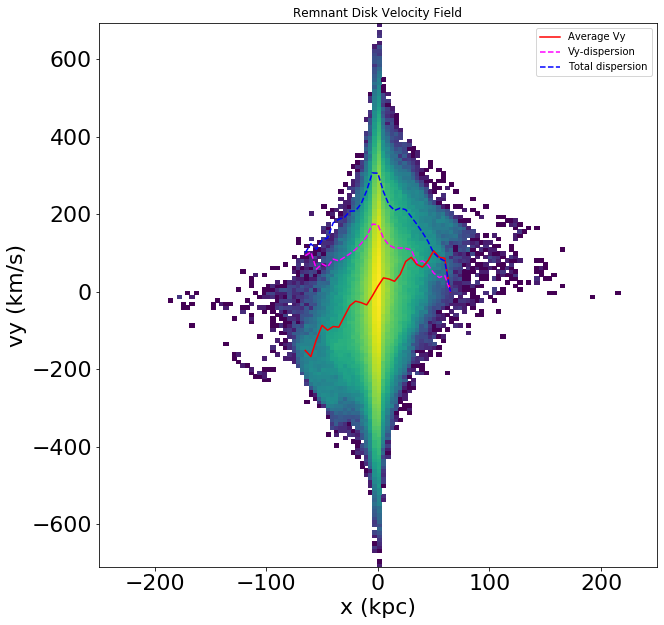

In [45]:
#overplot the means, dispersion in vy, and total dispersion as a function of axis on the phase diagram from above

xvalues = np.arange(-65, 70, 5)
# Make a phase diagram for each x, y, z axis, where v component is component that points out of board
# Remnant Disk Velocity Field

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot 2D Histogram one component of  Pos vs Vel 
# ADD HERE
plt.hist2d(rnew[:,0], vnew[:,1], bins = 150, norm=LogNorm())

plt.plot(xvalues, means, color = "red", label = "Average Vy")
plt.plot(xvalues, vydispersions, linestyle = "--", color = "magenta", label = "Vy-dispersion")
plt.plot(xvalues, totdispersions, linestyle = "--", color = "blue", label = "Total dispersion")

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('vy (km/s)', fontsize=22)
plt.title("Remnant Disk Velocity Field")
plt.xlim(-250,250)

#show legend
plt.legend()

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

#plt.savefig("/Users/Maddog/Downloads/RemnantDiskVelocityField.png")




In [76]:
#to get peak mean velocity, take peak velocity from means array (mean vy vs x)
peakvel = max(means)

#find the array element where the maximum value is 
peakvelindex = np.argmax(means)

In [47]:
#plot v/sigma as a function of position along axis

#set x values
xvalues = np.arange(-65, 70, 5)

#v over sigma ratio for just vy dispersions
voversig = np.divide(means,vydispersions)

#v over sigma ratio for total dispersion
voversigtot = np.divide(means,totdispersions)


/Users/Maddog/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/Maddog/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


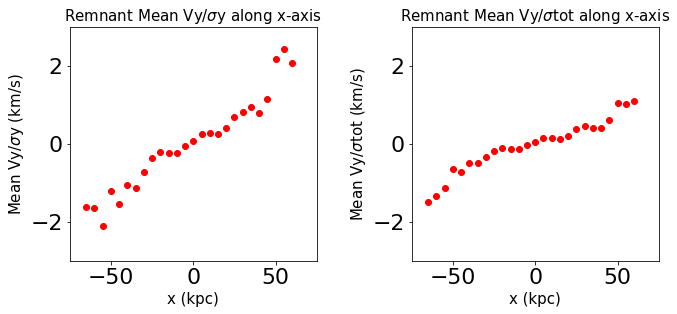

In [48]:
#create figure of v over sigma for both vy/sigma_y and vy/sigma_tot along x-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

#plots vy/sigma_y along x-axis
ax1.scatter(xvalues,voversig, color = "red")
ax1.set_xlabel('x (kpc)', fontsize = 15)
ax1.set_ylabel(r'Mean Vy/$\sigma$y (km/s)', fontsize = 15)
ax1.set_title(r"Remnant Mean Vy/$\sigma$y along x-axis", fontsize = 15)
ax1.set_ylim(-3,3)
ax1.set_xlim(-75,75)

#plots vy/sigma_tot along x-axis
ax2.scatter(xvalues,voversigtot, color = "red")
ax2.set_xlabel('x (kpc)', fontsize = 15)
ax2.set_ylabel(r'Mean Vy/$\sigma$tot (km/s)', fontsize = 15)
ax2.set_title(r"Remnant Mean Vy/$\sigma$tot along x-axis", fontsize = 15)
ax2.set_ylim(-3,3)
ax2.set_xlim(-75,75)

fig.tight_layout(pad=3.0)

#plt.savefig("/Users/Maddog/Downloads/RemnantVoverSig.png")



In [49]:
#take value of ratio where peakvel is, and that will determine whether the remnant is a slow or fast rotator
#for vy/sigma_y
peakratio = voversig[peakvelindex]
peakratio

2.1768396634311036

In [51]:
#take value of ratio where peakvel is, and that will determine whether the remnant is a slow or fast rotator
#for vy/sigma_tot
peakratio = voversigtot[peakvelindex]
peakratio

#higher than classical ellipticals!

1.0560776530478124

## Now follow the same process, but for along the z axis.  Just to see what it looks like!  The paper will be focused on going along the x-axis, but it was still cool to do this.

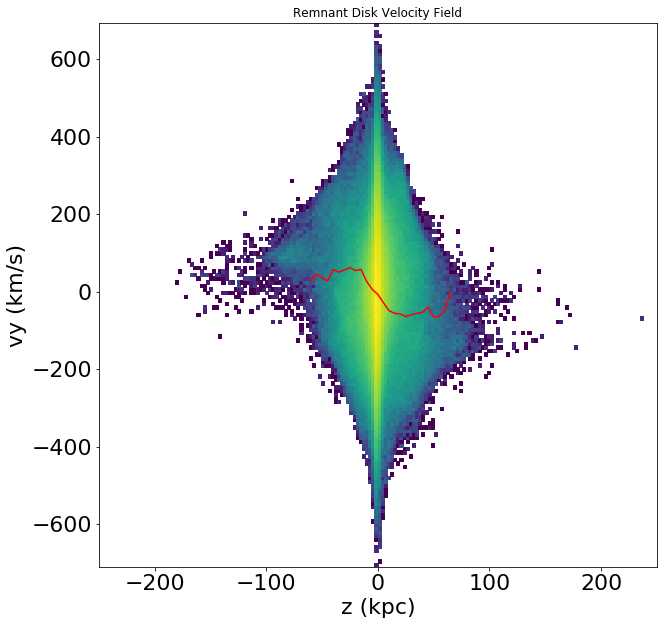

In [52]:
#make a phase diagram of mean vy along z 
#overplot the means as a function of axis on the phase diagram from above

zvalues = np.arange(-60, 70, 5)
# Make a phase diagram for each x, y, z axis, where v component is component that points out of board
# Remnant Disk Velocity Field

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot 2D Histogram one component of  Pos vs Vel 
# ADD HERE
plt.hist2d(rnew[:,2], vnew[:,1], bins = 150, norm=LogNorm())

plt.plot(zvalues, means2, color = "red")

# Add axis labels
plt.xlabel('z (kpc)', fontsize=22)
plt.ylabel('vy (km/s)', fontsize=22)
plt.title("Remnant Disk Velocity Field")
plt.xlim(-250,250)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size






In [54]:
#now find peakvy along z axis
#to get peak mean velocity, take peak velocity from means array (mean vy vs x)
peakvel2 = max(means2)

#find the array element where the maximum value is 
peakvelindex2 = np.argmax(means2)

/Users/Maddog/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/Maddog/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


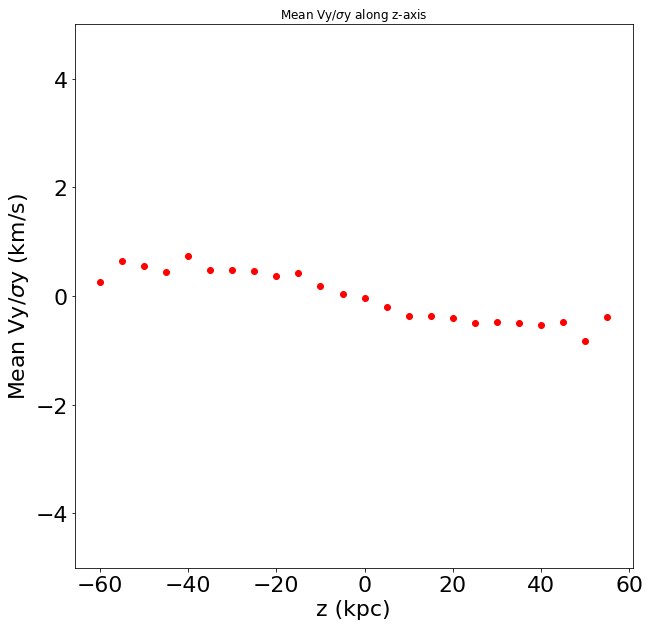

In [55]:
#plot vy/sigma_z as a function of position along z axis
voversig2 = np.divide(means2,vydispersions2)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

plt.scatter(zvalues, voversig2, color = "red")

# Add axis labels

plt.xlabel('z (kpc)', fontsize=22)
plt.ylabel(r'Mean Vy/$\sigma$y (km/s)', fontsize=22)
plt.title(r"Mean Vy/$\sigma$y along z-axis")
plt.ylim(-5,5)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

In [57]:
#display peat v/sigma ratio
peakratio2 = voversig2[peakvelindex2]
peakratio2

0.45252931771303306

## Again, follow a similar process as before but for the Milky Way at Snapshot 0 to compare with what we see in the remnant.

In [59]:
#read in data for MW at snap 000
time, total, data = Read("MW_000.txt")
    
#store data for wanted particle type 
index = np.where(data['type'] == 2)
x0 = data['x'][index]
y0 = data['y'][index]
z0 = data['z'][index]
vx0 = data['vx'][index]
vy0 = data['vy'][index]
vz0 = data['vz'][index]
mass0 = data['m'][index]

In [60]:
#combine into 3D arrays for position and velocity
r0 = np.array([x0,y0,z0]).T # transposed 
v0 = np.array([vx0,vy0,vz0]).T

In [61]:
#use function to rotate system from Lab 7
# a function that will rotate the position and velocity vectors
# so that the disk angular momentum is aligned with z axis. 
rnew0, vnew0 = RotateFrame(r0,v0)

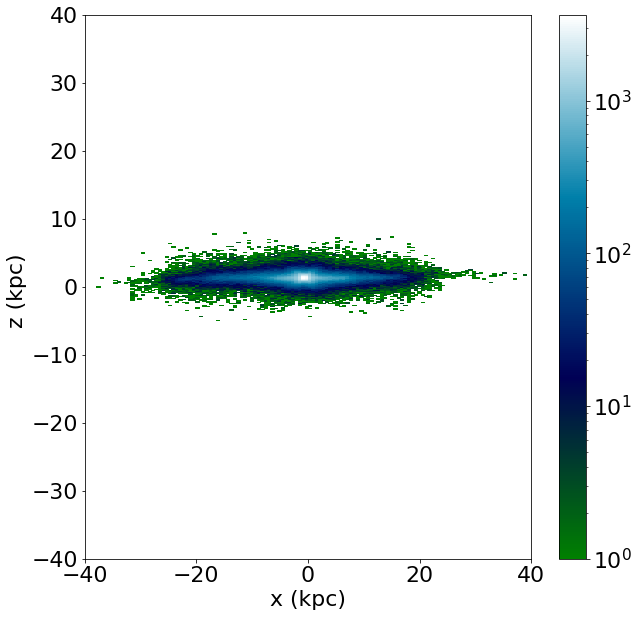

In [62]:
#MW Edge on
# Rotated Remnant (x-z plane)

# Remnant Density 
fig, ax= plt.subplots(figsize=(10, 10))

# plot the particle density for Remnant , 2D histogram
plt.hist2d(rnew0[:,0], rnew0[:,2], bins = 150, norm = LogNorm(), cmap = 'ocean')

plt.colorbar()

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('z (kpc) ', fontsize=22)

#set axis limits
plt.ylim(-40,40)
plt.xlim(-40,40)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

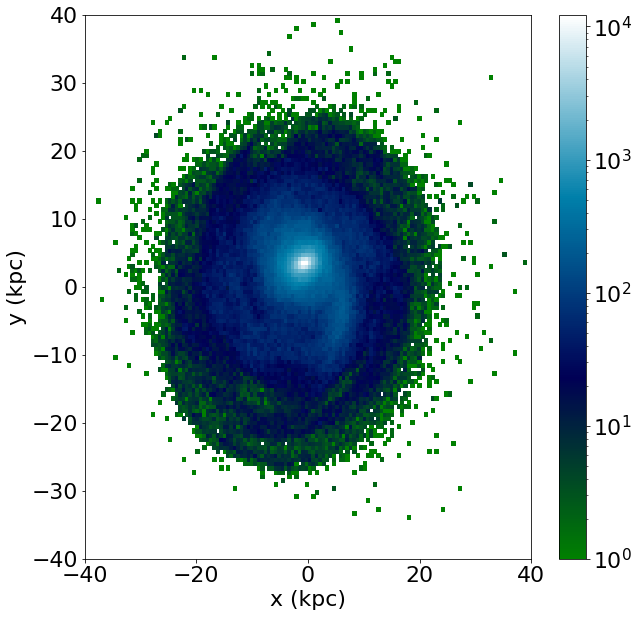

In [63]:
# MW snap 0 face on  - (x-y plane)

# MW Density 
fig, ax= plt.subplots(figsize=(10, 10))

# plot the particle density for remnant 
plt.hist2d(rnew0[:,0], rnew0[:,1], bins = 150, norm = LogNorm(), cmap = 'ocean')

plt.colorbar()

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('y (kpc)', fontsize=22)

#set axis limits
plt.ylim(-40,40)
plt.xlim(-40,40)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

In [68]:
#use VelocityMeansandDispersions to calculate means and dispersions along x axis of MW
MWmeans, MWvxdispersions, MWvydispersions, MWvzdispersions = VelocityMeansandDispersions("x", rnew0, vnew0, 1, 1, 1)

In [69]:
#calculate total dispersion for along x axis
MWtotdispersions = np.sqrt(MWvxdispersions**2 + MWvydispersions**2 + MWvzdispersions**2)

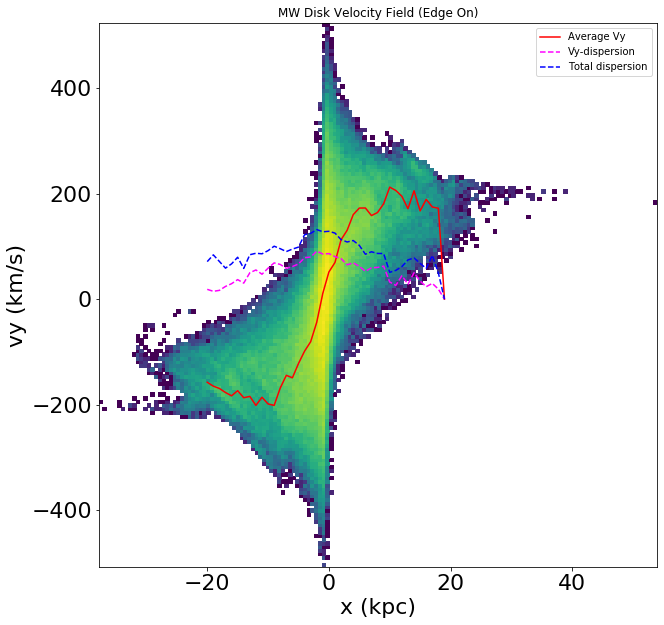

In [70]:
# Make a phase diagram for each x, y, z axis, where v component is component that points out of board
# MW Disk Velocity Field

xvalues = np.arange(-20.0,20.0, 1)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot 2D Histogram one component of  Pos vs Vel 
plt.hist2d(rnew0[:,0], vnew0[:,1], bins = 150, norm=LogNorm())

plt.plot(xvalues, MWmeans, color = "red", label = "Average Vy")
plt.plot(xvalues, MWvydispersions, linestyle = "--", color = "magenta", label = "Vy-dispersion")
plt.plot(xvalues, MWtotdispersions, linestyle = "--", color = "blue", label = "Total dispersion")

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('vy (km/s)', fontsize=22)
plt.title("MW Disk Velocity Field (Edge On)")

#show legend
plt.legend()

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

#save the figure
#plt.savefig("/Users/Maddog/Downloads/MWDiskVelocity.png")





/Users/Maddog/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


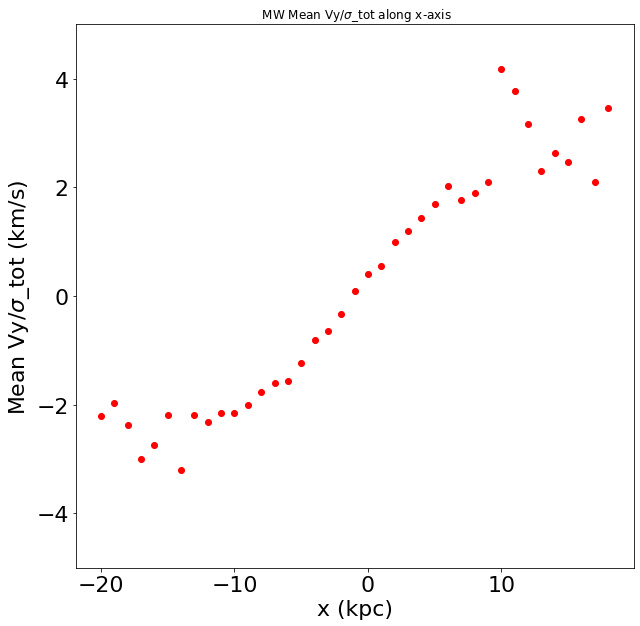

In [71]:
#plot v/sigma as a function of position along axis with peak vy and total dispersion
xvalues = np.arange(-20, 20, 1)
voversigtot = np.divide(MWmeans,MWtotdispersions)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

plt.scatter(xvalues, voversigtot, color = "red")

# Add axis labels

plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel(r'Mean Vy/$\sigma$_tot (km/s)', fontsize=22)
plt.title(r" MW Mean Vy/$\sigma$_tot along x-axis")
plt.ylim(-5,5)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

In [77]:
#to get peak mean velocity, take peak velocity from means array (mean vy vs x)
MWpeakvel = max(MWmeans)
MWpeakvel

#find the array element where the maximum value is 
peakvelindex = np.argmax(MWmeans)


In [78]:
#show peak v/sigma ratio
peakratioMW = voversigtot[peakvelindex]
peakratioMW

4.1733542109309205